In [671]:
# Import required libraries and dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

In [672]:
# Import the OHLCV dataset into a Pandas Dataframe
ohlcv_df = pd.read_csv(
    Path("emerging_markets_ohlcv.csv"),
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

ohlcv_df.reset_index(inplace=True)

# Review the DataFrame
display(ohlcv_df.head(5))

,date,open,high,low,close,volume
0,2015-01-21 09:30:00,23.83,23.83,23.83,23.83,100
1,2015-01-21 11:00:00,23.98,23.98,23.98,23.98,100
2,2015-01-22 15:00:00,24.42,24.42,24.42,24.42,100
3,2015-01-22 15:15:00,24.42,24.44,24.42,24.44,200
4,2015-01-22 15:30:00,24.46,24.46,24.46,24.46,200


In [673]:
# Rename columns and filter on date to eliminate duplicate closing prices for same day
ohlcv_df.rename(columns = {'date':'datetime'}, inplace = True)
ohlcv_df['date'] = pd.to_datetime(ohlcv_df['datetime']).dt.date
ohlcv_df.drop_duplicates(subset="date", keep="last", ignore_index=True, inplace=True)
ohlcv_df.head()


In [674]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["datetime", "close"]]

# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()
signals_df.set_index('datetime', inplace=True)

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

# Plot Actual Returns
signals_df.hvplot.line(y="Actual Returns")

,close,Actual Returns
datetime,,
2015-01-22 15:30:00,24.46,0.020017
2015-01-26 15:15:00,24.24,-0.008994
2015-01-27 15:45:00,24.12,-0.004950
2015-01-29 15:45:00,23.89,-0.009536
2015-01-30 13:30:00,23.75,-0.005860


,close,Actual Returns
datetime,,
2021-01-13 13:15:00,32.65,0.002149
2021-01-14 15:45:00,32.85,0.006126
2021-01-19 12:30:00,32.97,0.003653
2021-01-20 09:45:00,33.50,0.016075
2021-01-22 15:45:00,33.44,-0.001791


:Curve   [datetime]   (Actual Returns)

In [675]:
# Set the short window and long SMA windows
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively) in new signals1 dataframe
signals1_df = signals_df.copy()
signals1_df['SMA_Fast'] = signals1_df['close'].rolling(window=short_window).mean()
signals1_df['SMA_Slow'] = signals1_df['close'].rolling(window=long_window).mean()

signals1_df = signals1_df.dropna()

# Review the DataFrame
display(signals1_df.head())
display(signals1_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow
datetime,,,,
2015-10-07 15:45:00,22.20,0.022570,21.7800,23.6922
2015-10-08 15:45:00,22.50,0.013514,22.0475,23.6726
2015-10-12 15:30:00,22.35,-0.006667,22.1900,23.6537
2015-10-13 15:45:00,22.14,-0.009396,22.2975,23.6339
2015-10-14 12:30:00,22.16,0.000903,22.2875,23.6166


,close,Actual Returns,SMA_Fast,SMA_Slow
datetime,,,,
2021-01-13 13:15:00,32.65,0.002149,32.3200,27.6881
2021-01-14 15:45:00,32.85,0.006126,32.6325,27.7881
2021-01-19 12:30:00,32.97,0.003653,32.7625,27.8833
2021-01-20 09:45:00,33.50,0.016075,32.9925,27.9855
2021-01-22 15:45:00,33.44,-0.001791,33.1900,28.0855


In [676]:
# Initialize the new Signal column
signals1_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals1_df.loc[(signals1_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals1_df.loc[(signals1_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals1_df.head())
display(signals1_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
datetime,,,,,
2015-10-07 15:45:00,22.20,0.022570,21.7800,23.6922,1.0
2015-10-08 15:45:00,22.50,0.013514,22.0475,23.6726,1.0
2015-10-12 15:30:00,22.35,-0.006667,22.1900,23.6537,-1.0
2015-10-13 15:45:00,22.14,-0.009396,22.2975,23.6339,-1.0
2015-10-14 12:30:00,22.16,0.000903,22.2875,23.6166,1.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
datetime,,,,,
2021-01-13 13:15:00,32.65,0.002149,32.3200,27.6881,1.0
2021-01-14 15:45:00,32.85,0.006126,32.6325,27.7881,1.0
2021-01-19 12:30:00,32.97,0.003653,32.7625,27.8833,1.0
2021-01-20 09:45:00,33.50,0.016075,32.9925,27.9855,1.0
2021-01-22 15:45:00,33.44,-0.001791,33.1900,28.0855,-1.0


In [677]:
# Review distribution of Signal values
signals1_df['Signal'].value_counts()

 1.0    533
-1.0    427
Name: Signal, dtype: int64

In [678]:
# Calculate the strategy returns based on signal from previous day and add them to the signals1_df DataFrame
signals1_df['Strategy Returns'] = signals1_df['Actual Returns'] * signals1_df['Signal'].shift()
signals1_df = signals1_df.dropna()

# Review the DataFrame
display(signals1_df.head())
display(signals1_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
datetime,,,,,,
2015-10-08 15:45:00,22.50,0.013514,22.0475,23.6726,1.0,0.013514
2015-10-12 15:30:00,22.35,-0.006667,22.1900,23.6537,-1.0,-0.006667
2015-10-13 15:45:00,22.14,-0.009396,22.2975,23.6339,-1.0,0.009396
2015-10-14 12:30:00,22.16,0.000903,22.2875,23.6166,1.0,-0.000903
2015-10-15 11:15:00,22.28,0.005415,22.2325,23.6019,1.0,0.005415


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
datetime,,,,,,
2021-01-13 13:15:00,32.65,0.002149,32.3200,27.6881,1.0,0.002149
2021-01-14 15:45:00,32.85,0.006126,32.6325,27.7881,1.0,0.006126
2021-01-19 12:30:00,32.97,0.003653,32.7625,27.8833,1.0,0.003653
2021-01-20 09:45:00,33.50,0.016075,32.9925,27.9855,1.0,0.016075
2021-01-22 15:45:00,33.44,-0.001791,33.1900,28.0855,-1.0,-0.001791


<AxesSubplot:xlabel='datetime'>

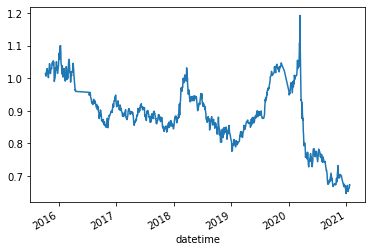

In [679]:
# Plot Strategy Returns to examine performance
(1 + signals1_df['Strategy Returns']).cumprod().plot()

In [680]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals1_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
datetime,,
2015-10-12 15:30:00,22.0475,23.6726
2015-10-13 15:45:00,22.1900,23.6537
2015-10-14 12:30:00,22.2975,23.6339
2015-10-15 11:15:00,22.2875,23.6166
2015-10-19 15:45:00,22.2325,23.6019


In [681]:
# Create the target set selecting the Signal column and assigning it to y
y = signals1_df['Signal']

# Review the value counts
y.value_counts()

 1.0    532
-1.0    427
Name: Signal, dtype: int64

In [682]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-10-12 15:30:00


In [683]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2016-01-12 15:30:00


In [684]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
datetime,,
2015-10-12 15:30:00,22.0475,23.6726
2015-10-13 15:45:00,22.1900,23.6537
2015-10-14 12:30:00,22.2975,23.6339
2015-10-15 11:15:00,22.2875,23.6166
2015-10-19 15:45:00,22.2325,23.6019


In [685]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Review the X_test DataFrame
X_test.head()

,SMA_Fast,SMA_Slow
datetime,,
2016-01-12 15:45:00,18.9000,22.18011
2016-01-13 14:45:00,18.7275,22.11841
2016-01-14 15:45:00,18.6625,22.05561
2016-01-15 15:45:00,18.6625,21.99741
2016-01-19 15:45:00,18.5275,21.93561


In [686]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [687]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the training data to make the model predictions
svm_pred_training = svm_model.predict(X_train_scaled)

# Review the model's predicted values
svm_pred_training[:40]


array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1.])

In [688]:
# Use a classification report to evaluate the model using the predictions and training data
svm_training_report = classification_report(y_train, svm_pred_training)

# Print the classification report
print(svm_training_report)


              precision    recall  f1-score   support

        -1.0       0.59      1.00      0.74        24
         1.0       0.00      0.00      0.00        17

    accuracy                           0.59        41
   macro avg       0.29      0.50      0.37        41
weighted avg       0.34      0.59      0.43        41



/Applications/anaconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [689]:
# Use the testing data to make the model predictions
svm_pred_testing = svm_model.predict(X_test_scaled)

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred_testing)
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.44      1.00      0.61       403
         1.0       0.00      0.00      0.00       514

    accuracy                           0.44       917
   macro avg       0.22      0.50      0.31       917
weighted avg       0.19      0.44      0.27       917



/Applications/anaconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [690]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index = X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred_testing

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = (
    predictions_df['Actual Returns'] * predictions_df['Predicted']
)

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
datetime,,,
2016-01-12 15:45:00,-1.0,0.002139,-0.002139
2016-01-13 14:45:00,-1.0,-0.011740,0.011740
2016-01-14 15:45:00,-1.0,0.009179,-0.009179
2016-01-15 15:45:00,-1.0,-0.028357,0.028357
2016-01-19 15:45:00,-1.0,0.011564,-0.011564


,Predicted,Actual Returns,Strategy Returns
datetime,,,
2021-01-13 13:15:00,-1.0,0.002149,-0.002149
2021-01-14 15:45:00,-1.0,0.006126,-0.006126
2021-01-19 12:30:00,-1.0,0.003653,-0.003653
2021-01-20 09:45:00,-1.0,0.016075,-0.016075
2021-01-22 15:45:00,-1.0,-0.001791,0.001791


<AxesSubplot:xlabel='datetime'>

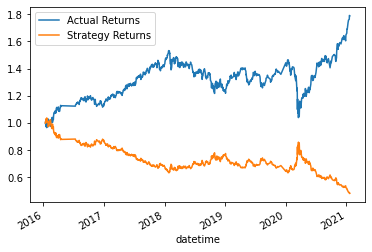

In [691]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[['Actual Returns', 'Strategy Returns']]).cumprod().plot()


In [692]:
# Tune the training algorithm by extending training period to 6 months
training_end = X.index.min() + DateOffset(months=6)
print(training_end)

2016-04-12 15:30:00


In [693]:
# Generate new X_train1 and y_train1 DataFrames
X_train1 = X.loc[training_begin:training_end]
y_train1 = y.loc[training_begin:training_end]

In [694]:
# Generate new X_test1 and y_test1 DataFrames
X_test1 = X.loc[training_end:]
y_test1 = y.loc[training_end:]
X_test1.head()

,SMA_Fast,SMA_Slow
datetime,,
2016-04-13 15:45:00,20.47225,20.2709
2016-04-14 15:45:00,20.57725,20.2775
2016-04-15 15:15:00,20.74475,20.2791
2016-04-18 15:30:00,20.81750,20.2741
2016-07-11 13:00:00,21.01500,20.2668


In [695]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train1 data
X_scaler = scaler.fit(X_train1)

# Transform the X_train1 and X_test1 DataFrames using the X_scaler
X_train1_scaled = X_scaler.transform(X_train1)
X_test1_scaled = X_scaler.transform(X_test1)

In [696]:
# From SVM, instantiate SVC classifier model instance
svm1_model = svm.SVC()

# Fit the model to the data using the training data
svm1_model = svm1_model.fit(X_train1_scaled, y_train1)

# Use the training data to make the model predictions
svm1_pred_training = svm1_model.predict(X_train1_scaled)
svm1_pred_training

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.])

In [697]:
# Use a classification report to evaluate the model using the predictions and training data
svm1_training_report = classification_report(y_train1, svm1_pred_training)
print(svm1_training_report)

              precision    recall  f1-score   support

        -1.0       0.59      0.50      0.54        46
         1.0       0.57      0.66      0.61        47

    accuracy                           0.58        93
   macro avg       0.58      0.58      0.58        93
weighted avg       0.58      0.58      0.58        93



In [698]:
# Use the testing data to make the model predictions
svm1_pred_testing = svm1_model.predict(X_test1_scaled)

# Use a classification report to evaluate the model using the predictions and testing data
svm1_testing_report = classification_report(y_test1, svm1_pred_testing)
print(svm1_testing_report)

              precision    recall  f1-score   support

        -1.0       0.43      0.62      0.51       381
         1.0       0.55      0.36      0.43       484

    accuracy                           0.48       865
   macro avg       0.49      0.49      0.47       865
weighted avg       0.50      0.48      0.47       865



In [699]:
# Create a predictions DataFrame
predictions1_df = pd.DataFrame(index=X_test1.index)

# Add the SVM model predictions to the DataFrame
predictions1_df['Predicted'] = svm1_pred_testing

# Add the actual returns to the DataFrame
predictions1_df['Actual Returns'] = signals1_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions1_df['Strategy Returns'] = (
    predictions1_df['Actual Returns'] * predictions2_df['Predicted']
)
display(predictions1_df.head())
display(predictions1_df.tail())

,Predicted,Actual Returns,Strategy Returns
datetime,,,
2016-04-13 15:45:00,1.0,0.041461,0.041461
2016-04-14 15:45:00,1.0,-0.005687,-0.005687
2016-04-15 15:15:00,1.0,-0.002383,-0.002383
2016-04-18 15:30:00,1.0,0.005733,0.005733
2016-07-11 13:00:00,1.0,-0.002850,-0.002850


,Predicted,Actual Returns,Strategy Returns
datetime,,,
2021-01-13 13:15:00,1.0,0.002149,0.002149
2021-01-14 15:45:00,1.0,0.006126,0.006126
2021-01-19 12:30:00,1.0,0.003653,0.003653
2021-01-20 09:45:00,1.0,0.016075,0.016075
2021-01-22 15:45:00,1.0,-0.001791,-0.001791


<AxesSubplot:xlabel='datetime'>

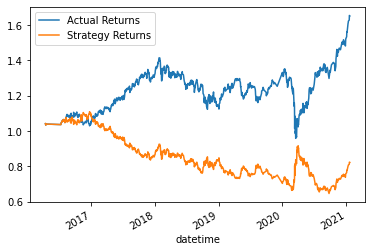

In [700]:
# Plot the actual returns versus the strategy returns
(1 + predictions1_df[['Actual Returns', 'Strategy Returns']]).cumprod().plot()

In [701]:
# Tune the training algorithm by extending short SMA window to 8 days
short2_window = 8
long_window = 100

# Generate the fast and slow simple moving averages (8 and 100 days, respectively) in new signals2 dataframe
signals2_df = signals_df.copy()
signals2_df['SMA2_Fast'] = signals2_df['close'].rolling(window=short2_window).mean()
signals2_df['SMA_Slow'] = signals2_df['close'].rolling(window=long_window).mean()
signals2_df = signals2_df.dropna()
display(signals2_df.head())
display(signals2_df.tail())

,close,Actual Returns,SMA2_Fast,SMA_Slow
datetime,,,,
2015-10-07 15:45:00,22.20,0.022570,21.45875,23.6922
2015-10-08 15:45:00,22.50,0.013514,21.58250,23.6726
2015-10-12 15:30:00,22.35,-0.006667,21.65375,23.6537
2015-10-13 15:45:00,22.14,-0.009396,21.86625,23.6339
2015-10-14 12:30:00,22.16,0.000903,22.03375,23.6166


,close,Actual Returns,SMA2_Fast,SMA_Slow
datetime,,,,
2021-01-13 13:15:00,32.65,0.002149,31.78500,27.6881
2021-01-14 15:45:00,32.85,0.006126,32.04125,27.7881
2021-01-19 12:30:00,32.97,0.003653,32.28000,27.8833
2021-01-20 09:45:00,33.50,0.016075,32.52875,27.9855
2021-01-22 15:45:00,33.44,-0.001791,32.75500,28.0855


In [702]:
# Assign a copy of the sma2_fast and sma_slow columns to a features DataFrame called X
X = signals2_df[['SMA2_Fast', 'SMA_Slow']].shift().dropna()
X.head()

,SMA2_Fast,SMA_Slow
datetime,,
2015-10-08 15:45:00,21.45875,23.6922
2015-10-12 15:30:00,21.58250,23.6726
2015-10-13 15:45:00,21.65375,23.6537
2015-10-14 12:30:00,21.86625,23.6339
2015-10-15 11:15:00,22.03375,23.6166


In [703]:
# Select the start of the training period
training_begin = X.index.min()
print(training_begin)

2015-10-08 15:45:00


In [704]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)
print(training_end)

2016-01-08 15:45:00


In [705]:
# Generate new X_train2 and y_train DataFrames
X_train2 = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train2.head()

,SMA2_Fast,SMA_Slow
datetime,,
2015-10-08 15:45:00,21.45875,23.6922
2015-10-12 15:30:00,21.58250,23.6726
2015-10-13 15:45:00,21.65375,23.6537
2015-10-14 12:30:00,21.86625,23.6339
2015-10-15 11:15:00,22.03375,23.6166


In [706]:
# Generate the X_test2 and y_test DataFrames
X_test2 = X.loc[training_end:]
y_test = y.loc[training_end:]

# Review the X_test DataFrame
X_test2.head()

,SMA2_Fast,SMA_Slow
datetime,,
2016-01-08 15:45:00,19.93750,22.32301
2016-01-11 15:45:00,19.67750,22.24861
2016-01-12 15:45:00,19.42500,22.18011
2016-01-13 14:45:00,19.21875,22.11841
2016-01-14 15:45:00,18.99500,22.05561


In [707]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train2 data
X_scaler = scaler.fit(X_train2)

# Transform the X_train2 and X_test2 DataFrames using the X_scaler
X_train2_scaled = X_scaler.transform(X_train2)
X_test2_scaled = X_scaler.transform(X_test2)

In [708]:
# From SVM, instantiate SVC classifier model instance
svm2_model = svm.SVC()

# Fit the model to the data using the training data
svm2_model = svm2_model.fit(X_train2_scaled, y_train)

# Use the training data to make the model predictions
svm2_pred_training = svm2_model.predict(X_train2_scaled)
svm2_pred_training[:40]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1.])

In [709]:
# Use a classification report to evaluate the model using the predictions and training data
svm2_training_report = classification_report(y_train, svm2_pred_training)
print(svm2_training_report)

              precision    recall  f1-score   support

        -1.0       0.59      1.00      0.74        24
         1.0       0.00      0.00      0.00        17

    accuracy                           0.59        41
   macro avg       0.29      0.50      0.37        41
weighted avg       0.34      0.59      0.43        41



/Applications/anaconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [710]:
# Use the testing data to make the model predictions
svm2_pred_testing = svm2_model.predict(X_test2_scaled)

# Use a classification report to evaluate the model using the predictions and testing data
svm2_testing_report = classification_report(y_test, svm2_pred_testing)
print(svm2_testing_report)

              precision    recall  f1-score   support

        -1.0       0.44      1.00      0.61       404
         1.0       0.00      0.00      0.00       515

    accuracy                           0.44       919
   macro avg       0.22      0.50      0.31       919
weighted avg       0.19      0.44      0.27       919



/Applications/anaconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Step 3: Choose the set of parameters that best improved the trading algorithm returns. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns, and document your conclusion in your `README.md` file.

In [712]:
# Create a predictions DataFrame
predictions2_df = pd.DataFrame(index=X_test2.index)

# Add the SVM model predictions to the DataFrame
predictions2_df['Predicted'] = svm2_pred_testing

# Add the actual returns to the DataFrame
predictions2_df['Actual Returns'] = signals2_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions2_df['Strategy Returns'] = (
    predictions2_df['Actual Returns'] * predictions2_df['Predicted']
)
display(predictions2_df.head())
display(predictions2_df.tail())

,Predicted,Actual Returns,Strategy Returns
datetime,,,
2016-01-08 15:45:00,-1.0,-0.004792,0.004792
2016-01-11 15:45:00,-1.0,0.000535,-0.000535
2016-01-12 15:45:00,-1.0,0.002139,-0.002139
2016-01-13 14:45:00,-1.0,-0.011740,0.011740
2016-01-14 15:45:00,-1.0,0.009179,-0.009179


,Predicted,Actual Returns,Strategy Returns
datetime,,,
2021-01-13 13:15:00,-1.0,0.002149,-0.002149
2021-01-14 15:45:00,-1.0,0.006126,-0.006126
2021-01-19 12:30:00,-1.0,0.003653,-0.003653
2021-01-20 09:45:00,-1.0,0.016075,-0.016075
2021-01-22 15:45:00,-1.0,-0.001791,0.001791


<AxesSubplot:xlabel='datetime'>

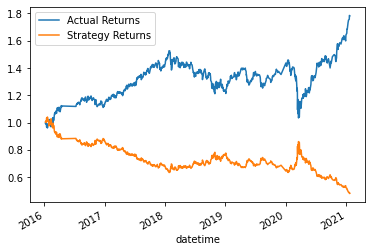

In [713]:
# Plot the actual returns versus the strategy returns
(1 + predictions2_df[['Actual Returns', 'Strategy Returns']]).cumprod().plot()

In [715]:
# Import AdaBoost classifier from SKLearn
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=100)


In [716]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-10-08 15:45:00


In [717]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2016-01-08 15:45:00


In [719]:
# Generate the X_train2 and y_train DataFrames
X_train2 = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train2.head()

,SMA2_Fast,SMA_Slow
datetime,,
2015-10-08 15:45:00,21.45875,23.6922
2015-10-12 15:30:00,21.58250,23.6726
2015-10-13 15:45:00,21.65375,23.6537
2015-10-14 12:30:00,21.86625,23.6339
2015-10-15 11:15:00,22.03375,23.6166


In [720]:
# Generate the X_test2 and y_test DataFrames
X_test2 = X.loc[training_end:]
y_test = y.loc[training_end:]

# Review the X_test DataFrame
X_test2.head()

,SMA2_Fast,SMA_Slow
datetime,,
2016-01-08 15:45:00,19.93750,22.32301
2016-01-11 15:45:00,19.67750,22.24861
2016-01-12 15:45:00,19.42500,22.18011
2016-01-13 14:45:00,19.21875,22.11841
2016-01-14 15:45:00,18.99500,22.05561


In [722]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train2 data
X_scaler = scaler.fit(X_train2)

# Transform the X_train2 and X_test2 DataFrames using the X_scaler
X_train_scaled2 = X_scaler.transform(X_train2)
X_test_scaled2 = X_scaler.transform(X_test2)

In [723]:
# Fit the model using the training data
model = clf.fit(X_train_scaled2, y_train)

# Use the training dataset to generate the predictions for the new model
clf_pred_training = clf.predict(X_train_scaled2)

#Review the model's predicted values
clf_pred_training

array([ 1., -1., -1.,  1.,  1.,  1., -1.,  1., -1., -1., -1.,  1.,  1.,
       -1.,  1., -1., -1., -1.,  1.,  1.,  1., -1., -1.,  1., -1., -1.,
       -1., -1.,  1.,  1.,  1., -1.,  1., -1., -1., -1., -1.,  1., -1.,
       -1., -1.])

In [724]:
# Use a classification report to evaluate the model using the predictions and training data
clf_training_report = classification_report(y_train, clf_pred_training)
print(clf_training_report)

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00        24
         1.0       1.00      1.00      1.00        17

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41



In [726]:
# Use the testing data to make the model predictions
clf_pred_testing = model.predict(X_test2_scaled)

# Use a classification report to evaluate the model using the predictions and testing data
clf_testing_report = classification_report(y_test, clf_pred_testing)
print(clf_testing_report)

              precision    recall  f1-score   support

        -1.0       0.44      0.98      0.61       404
         1.0       0.61      0.03      0.05       515

    accuracy                           0.45       919
   macro avg       0.52      0.50      0.33       919
weighted avg       0.53      0.45      0.30       919



In [727]:
# Use a classification report to evaluate the model using the predictions and testing data
clf_testing_report = classification_report(y_test, clf_pred_testing)

# Print the classification report
print(clf_testing_report)


              precision    recall  f1-score   support

        -1.0       0.44      0.98      0.61       404
         1.0       0.61      0.03      0.05       515

    accuracy                           0.45       919
   macro avg       0.52      0.50      0.33       919
weighted avg       0.53      0.45      0.30       919



In [728]:
# Create a predictions DataFrame
clf_pred_df = pd.DataFrame(index=X_test2.index)

# Add the SVM model predictions to the DataFrame
clf_pred_df['Predicted'] = clf_pred_testing

# Add the actual returns to the DataFrame
clf_pred_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
clf_pred_df['Strategy Returns'] = (
    clf_pred_df['Actual Returns'] * clf_pred_df['Predicted']
)
                                   

# Review the DataFrame
display(clf_pred_df.head())


,Predicted,Actual Returns,Strategy Returns
datetime,,,
2016-01-08 15:45:00,-1.0,-0.004792,0.004792
2016-01-11 15:45:00,-1.0,0.000535,-0.000535
2016-01-12 15:45:00,-1.0,0.002139,-0.002139
2016-01-13 14:45:00,-1.0,-0.011740,0.011740
2016-01-14 15:45:00,-1.0,0.009179,-0.009179


<AxesSubplot:xlabel='datetime'>

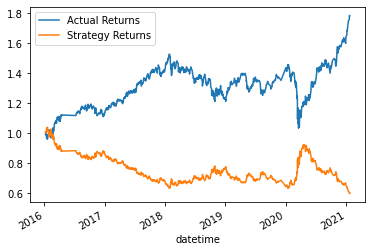

In [729]:
# Plot the actual returns versus the strategy returns
(1 + clf_pred_df[['Actual Returns', 'Strategy Returns']]).cumprod().plot()